<a href="https://colab.research.google.com/github/Maziger/master-generative-ai-with-llm/blob/main/Notebooks/Take_home_exam_assignments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hugging face setup

In [3]:
# Logging in
from google.colab import userdata
import os
from huggingface_hub import login
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')
login(os.environ['HF_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# Assignment 1
Follow the classification example in Chapter 6 in Hands-On Generative AI with Transformers and Diffusion Models and extend it in the following ways:

## 1. Perform an error analysis based on the fine-tuned DestilBert model on the AG News dataset.

### Fine-tuning DestilBert

* Printing and logging settings

In [ ]:
import datasets
import numpy as np
import torch
import transformers

np.set_printoptions(edgeitems=10, linewidth=70)
torch.set_printoptions(edgeitems=10, linewidth=70)
transformers.logging.set_verbosity_warning()
datasets.logging.set_verbosity_error()

* Load in the AG News dataset

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("ag_news")
raw_datasets

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

120.000 training rows
7.600 test rows

In [ ]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [ ]:
print(raw_train_dataset.features)

{'text': Value('string'), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'])}


* Categories: [World, Sports, Business, Sci/Tech]

* Tokenize the dataset

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )


tokenize_function(raw_train_dataset[:2])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

{'input_ids': tensor([[  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,
          1996,  2304,  1006, 26665,  1007, 26665,  1011,  2460,
          1011, 19041,  1010,  2813,  2395,  1005,  1055,  1040,
         11101,  2989,  1032,  2316,  1997, 11087,  1011, 22330,
          8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101, 18431,  2571,  3504,  2646,  3293, 13395,  1006,
         26665,  1007, 26665,  1011,  2797,  5211,  3813, 18431,
          2571,  2177,  1010,  1032,  2029,  2038,  1037,  5891,
          2005,  2437,  2092,  1011, 22313,  1998,  5681,  1032,
          6801,  3248,  1999,  1996,  3639,  3068,  1010,  2038,
          5168,  2872,  1032,  2049, 29475,  2006,  2178,  2112,
          1997,  1996,  3006,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 

* Adding input_ids and attention_mask

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

* Define evaluation metrics

In [ ]:
%pip install

import evaluate

ERROR: You must give at least one requirement to install (see "pip help install")


In [ ]:
accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy and F1 Score
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

* Connect to GPU

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


* Train model

In [ ]:
from transformers import TrainingArguments

batch_size = 32  # Can be adjusted depending on GPU size
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)
training_args = TrainingArguments(
    "assignment1_DestilBert",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none" # Adding this to avoid setup wandb
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer

# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)
trainer.train()

/tmp/ipython-input-2244742712.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.270980,0.909211,0.908877
2,0.303400,0.244667,0.920658,0.920620


TrainOutput(global_step=626, training_loss=0.278228912109765, metrics={'train_runtime': 731.5129, 'train_samples_per_second': 27.341, 'train_steps_per_second': 0.856, 'total_flos': 1875180164398464.0, 'train_loss': 0.278228912109765, 'epoch': 2.0})

Model showcases an F1 score on the validation set of approx. 92%

* Share model to hugging face

In [ ]:
trainer.push_to_hub(commit_message="Completed training")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...nment1_DestilBert/training_args.bin: 100%|##########| 5.78kB / 5.78kB            

  ...nment1_DestilBert/model.safetensors:  12%|#2        | 33.5MB /  268MB            

CommitInfo(commit_url='https://huggingface.co/Maziger1/assignment1_DestilBert/commit/fa488c768eb3f6c53023fce716e6fea17f678201', commit_message='Completed training', commit_description='', oid='fa488c768eb3f6c53023fce716e6fea17f678201', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maziger1/assignment1_DestilBert', endpoint='https://huggingface.co', repo_type='model', repo_id='Maziger1/assignment1_DestilBert'), pr_revision=None, pr_num=None)

* Test if our the model works on a sample text
  * Had to make adjustments to get the correct label output

In [ ]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# Manually load model with label mapping
model = AutoModelForSequenceClassification.from_pretrained(
    "Maziger1/assignment1_DestilBert",
    id2label=raw_train_dataset.features["label"]._int2str
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("Maziger1/assignment1_DestilBert")

# Create pipeline with model and tokenizer
pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device="cuda"
)
pipe(
    """The soccer match between Spain and
Portugal ended in a terrible result for Portugal."""
)

Device set to use cuda


[{'label': 'Sports', 'score': 0.9189889430999756}]

* Plot confusion matrix

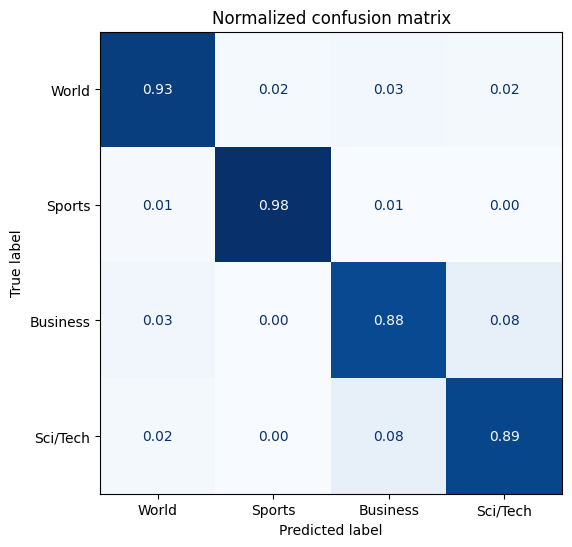

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Convert predicted labels to ids
label_to_id = {name: i for i, name in enumerate(label_names)}
# Extract the numerical part of the predicted label string (e.g., 'LABEL_2' -> 2)
pred_labels = [int(pred["label"].split('_')[1]) for pred in model_preds]

# Compute confusion matrix
confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=references, predictions=pred_labels, normalize="true"
)["confusion_matrix"]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix")
plt.show()

Noticeable that the Business category is sometimes confused with Sci/Tech (0.08). And the Sci/Tech category is sometimes confused with Business (0.08).

### Error analysis (DestilBert)

* Use GPU if available

In [ ]:
import torch
from torch.nn.functional import cross_entropy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Create label mapping function
label_names = raw_train_dataset.features["label"].names
def label_int2str(label_int):
    return label_names[label_int]

# Process one example at a time
def forward_pass_single(example):
    # Prepare inputs for a single example (values are already tensors)
    inputs = {k: example[k].unsqueeze(0).to(device)
              for k in tokenizer.model_input_names if k in example}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, example["label"].unsqueeze(0).to(device),
                           reduction="none")

    return {"loss": loss.cpu().numpy()[0],
            "predicted_label": pred_label.cpu().numpy()[0]}

In [ ]:
# Convert your test dataset to PyTorch tensors
tokenized_datasets["test"].set_format("torch",
                                     columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Process each example individually
print("Processing test dataset for error analysis...")
test_with_loss = tokenized_datasets["test"].map(forward_pass_single)

# Convert back to pandas for analysis
test_with_loss.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = test_with_loss[:][cols]

Processing test dataset for error analysis...


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Convert label integers to strings
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

* Sort the tokenized_datasets by model loss (high)

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
912,Bryant Makes First Appearance at Trial (AP) AP...,Sci/Tech,Sports,6.568706
1269,Philippines mourns dead in Russian school sieg...,Sci/Tech,World,6.523560
4300,City Series-ly wounded With the Yanks out of t...,Sports,Business,6.410667
1317,Florida deaths blamed on Hurricane Frances Sta...,Sports,World,6.252581
6405,Madrid miffed! The organisers of Madrid #39;s ...,Sports,World,6.076988
1197,World briefs LONDON - A man wielding a machete...,Business,World,6.067928
2126,Bush Scraps Most U.S. Sanctions on Libya (Reut...,Sci/Tech,World,6.062177
2833,Man arrested for fatally stabbing elderly pare...,Sci/Tech,World,6.025840
7228,Indonesian diplomats asked to help improve RI ...,Business,World,5.955022
5127,Another homicide in Holland It is a sad day. ...,Sci/Tech,World,5.910108


The model has trouble with predicting some of the labels, which may be due to the data itself having mislabeled some categories.

We can see that the Sci/Tech label has atleast four instances, where the text doesn't relate to that category at all. For instance, 912 being sports related, 1269 being world related etc.

Some of the business labels also seem to mislabelled in the dataset and should instead be categorised as world.

Having this information can help us refine the dataset for better performance.

* Sort the tokenized_datasets by model loss (low)

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
780,"Yemen Jails 5 Over Limburg, US Envoy Murder Pl...",World,World,0.003938
4910,Japan confirms captive in Iraq beheaded Japan ...,World,World,0.003960
7368,Kidnapped Turk Killed in Afghanistan -- Witnes...,World,World,0.003965
2137,Karzai deputy escapes a roadside bombing A dep...,World,World,0.003969
129,Peace delegation leaves Najaf empty-handed as ...,World,World,0.003975
4471,Egypt Arrests Alleged Sinai Bombers (AP) AP - ...,World,World,0.003990
775,Eritreans deported by Libya hijack a plane KHA...,World,World,0.003991
5296,France Says Hostages Still Alive a Few Days Ag...,World,World,0.003994
993,Iraq #39;s Chalabi escapes attempt on his life...,World,World,0.003996
3749,"Israel Arrests Bombing Suspect, Kills 4 Milita...",World,World,0.004006


The model is very confident when predicting the world category.

Judging from both the ascending and descending model loss, it seems like the model is good at exploiting whenever a country or geographical location is mentioned in the text, to the classify it as world. This could prove to be an issue when the model has to categorize business, which is also likely to include similar geographical keywords.

## 2. Fine-tune a ModernBert model (answerdotai/ModernBERT-base) in a similar fashion as DestilBert was fine-tuned in the chapter.

* Tokenize the dataset changing the checkpoint

In [ ]:
from transformers import AutoTokenizer

checkpoint = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )

tokenize_function(raw_train_dataset[:2])

{'input_ids': tensor([[50281, 24115,   659,    15, 34105,  1639,  1403,  8247, 40688,   253,
          5418,   313, 32680,    10, 24197,   428, 14196,    14,    84, 20945,
            13,  8799,  5720,   434,   277, 16668,  1981,    61,  4152,   273,
         17452,    14,   951,    79,   982,    13,   403,  6523,  4759,   969,
            15, 50282, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283],
        [50281,    36,  1285,   282, 44357, 24819,   472, 27811, 37785, 36119,
           313, 32680,    10, 24197,   428, 20859,  8149,  5882,   330,  1285,
           282,  5901,  1337,  4609,   556,   247, 12681,   323,  2403,   973,
            14, 12292,   264,   285, 13949,    61, 43961,   735,   451,  7120,
           275,   253,  5684,  4491,    13,   556, 16092,  4845,    61,   953,
         45780,   327,  1529,   629,   273,   253,  2791,    15, 50282]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 

* Adding input_ids and attention_mask

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

* Define evaluation metrics

In [ ]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy and F1 Score
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

* Connect to GPU

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cuda


* Train ModernBert model

In [ ]:
from transformers import TrainingArguments

batch_size = 32  # Can be adjusted depending on GPU size
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)
training_args = TrainingArguments(
    "assignment1_ModernBert",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none" # Adding this to avoid setup wandb
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer

# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)
trainer.train()

/tmp/ipython-input-2244742712.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0915 15:21:30.615000 1545 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.245964,0.915395,0.915232
2,0.275300,0.249700,0.923553,0.923460


TrainOutput(global_step=626, training_loss=0.2459266894160749, metrics={'train_runtime': 856.3633, 'train_samples_per_second': 23.355, 'train_steps_per_second': 0.731, 'total_flos': 4393473122366208.0, 'train_loss': 0.2459266894160749, 'epoch': 2.0})

* Share model to hugging face

In [ ]:
trainer.push_to_hub(commit_message="Completed training ModernBert")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...nment1_ModernBert/training_args.bin: 100%|##########| 5.78kB / 5.78kB            

  ...nment1_ModernBert/model.safetensors:   7%|6         | 41.9MB /  598MB            

CommitInfo(commit_url='https://huggingface.co/Maziger1/assignment1_ModernBert/commit/f12156decd0c7693ac216737bdeff8d5a1b343c5', commit_message='Completed training ModernBert', commit_description='', oid='f12156decd0c7693ac216737bdeff8d5a1b343c5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maziger1/assignment1_ModernBert', endpoint='https://huggingface.co', repo_type='model', repo_id='Maziger1/assignment1_ModernBert'), pr_revision=None, pr_num=None)

## 3. Compare the test set performance of the two fine-tuned models.

* Test performance from DestilBert

In [ ]:
from transformers import Trainer

# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)
trainer.train()

/tmp/ipython-input-2244742712.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.270980,0.909211,0.908877
2,0.303400,0.244667,0.920658,0.920620


TrainOutput(global_step=626, training_loss=0.278228912109765, metrics={'train_runtime': 731.5129, 'train_samples_per_second': 27.341, 'train_steps_per_second': 0.856, 'total_flos': 1875180164398464.0, 'train_loss': 0.278228912109765, 'epoch': 2.0})

* Test performance from ModernBert

In [ ]:
from transformers import Trainer

# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)
trainer.train()

/tmp/ipython-input-2244742712.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0915 15:21:30.615000 1545 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.245964,0.915395,0.915232
2,0.275300,0.249700,0.923553,0.923460


TrainOutput(global_step=626, training_loss=0.2459266894160749, metrics={'train_runtime': 856.3633, 'train_samples_per_second': 23.355, 'train_steps_per_second': 0.731, 'total_flos': 4393473122366208.0, 'train_loss': 0.2459266894160749, 'epoch': 2.0})

Comparing the test performance of the models:
  * Accuracy score:
    * 92.07% (DestilBert) | 92.36% (ModernBert)
  * F1 Score:
    * 92.06% (DestilBert) | 92.35% (ModernBert)
  * Validation loss:
    * 0.2447 (DestilBert) | 0.2497 (ModernBert)

We can see that the ModernBert has a slightly better performance in Accuracy and F1 Score, although DistilBert poses a better validation loss.
This slight improvement in performance is to be expected from ModernBert, as it is more powerful and efficient than DistilBert. However, both models seem to be performing quite similarly on our task, given the difference between them is so small. Overall, the accuracy of them both being above 92% is deemed high and could potentially be improven by refining the dataset as previously mentioned.

## 4. Perform an error analysis on the AG News based on the fine-tuned ModernBert and compare it to DestilBert.

### Error analysis (ModernBert)

* Load ModernBert model from HF

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.nn.functional import cross_entropy

checkpoint = "Maziger1/assignment1_ModernBert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Load trained model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint).to(device)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )

Using device: cuda


In [ ]:
# Create label mapping function
label_names = raw_train_dataset.features["label"].names
def label_int2str(label_int):
    return label_names[label_int]

# Process one example at a time
def forward_pass_single(example):
    # Prepare inputs for a single example (values are already tensors)
    inputs = {k: example[k].unsqueeze(0).to(device)
              for k in tokenizer.model_input_names if k in example}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, example["label"].unsqueeze(0).to(device), reduction="none")

    return {"loss": loss.cpu().numpy()[0],
            "predicted_label": pred_label.cpu().numpy()[0]}

In [ ]:
# Tokenize and convert test dataset to PyTorch tensors
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets["test"].set_format("torch",
                                     columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Process each example individually
print("Processing test dataset for error analysis...")
test_with_loss = tokenized_datasets["test"].map(forward_pass_single)

# Convert back to pandas for analysis
test_with_loss.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = test_with_loss[:][cols]

# Convert label integers to strings
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

Processing test dataset for error analysis...


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

* Sort the tokenized_datasets by model loss (high)

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1197,World briefs LONDON - A man wielding a machete...,Business,World,12.103226
1269,Philippines mourns dead in Russian school sieg...,Sci/Tech,World,12.072771
4396,Revolving Door &lt;em&gt; IN&lt;/em&gt;&lt;br...,World,Business,11.232325
7228,Indonesian diplomats asked to help improve RI ...,Business,World,10.588847
1364,Hyundai signs deal for China truck plant Hyund...,Sci/Tech,Business,10.376899
4097,"Greenspan: Debt, home prices not dangerous The...",Sci/Tech,Business,9.980994
2833,Man arrested for fatally stabbing elderly pare...,Sci/Tech,World,9.927932
248,Caterpillar snaps up another remanufacturer of...,Sci/Tech,Business,9.603634
5674,Will Hutton There were two stories last week t...,Business,World,9.425412
2660,Gas prices up 5 cents after Hurricane Ivan CAM...,Sci/Tech,Business,9.073890


We see some similar tendencies in ModernBert. It is also struggling with predicting labels of the indices 1269, 1197 and 7228. Which are mislabelled in the dataset and can be corrected.

Again we see that Sci/Tech is mislabelled in many instances where it properly should be categorised as Business.

* Sort the tokenized_datasets by model loss (low)

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
2108,Car Bomb Kills Three in Mosul (AP) AP - A car ...,World,World,2.384186e-07
7029,"Six Iraqi national guards, 10 civilians wounde...",World,World,3.576278e-07
1298,"Clashes in Baghdad Slum Kill 22 Iraqis, U.S. S...",World,World,4.768370e-07
999,"Gunmen ambush Chalabi #39;s convoy, wound 2 BA...",World,World,4.768370e-07
3344,Two U.S. Soldiers Killed in Iraq Bombings (AP)...,World,World,4.768370e-07
1316,Fierce Clashes in Iraq Kill 36; 203 Hurt US tr...,World,World,4.768370e-07
7197,"Four Israeli soldiers killed, Barghuti pulls o...",World,World,5.960463e-07
1299,"Fierce Clashes in Iraq Kill 34 People BAGHDAD,...",World,World,5.960463e-07
6384,UK minister visits Arafat grave UK Foreign Sec...,World,World,5.960463e-07
5403,Calif. Official Backs Anthem-WellPoint LOS AN...,Business,Business,7.152555e-07


Similarly to the DestilBert model, ModernBert is also the most confident in predicting the category World. Most likely due to the mentioning of a geographical area or a nationality.

Comparing the error analysis made on each model.

# Assignment 2
Perform the fine-tuning exercise from Chapter 6 in Hands-on Generative AI with Transformers with Transformers and Diffusion Models, but use HuggingFaceTB/SmolLM2-135M instead.
The goal is to tweak tuning parameters to get healthy looking training-validation curves and reasonable sounding output. Show examples of each from two selected training runs: One that shows warnings signs and one that shows the desired behavior.

## First model w. SmolLM2-135M

* Load dataset

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("ag_news")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

* Remove labelled data from the dataset

In [ ]:
filtered_datasets = raw_datasets.filter(lambda example: example["label"] == 2)
filtered_datasets = filtered_datasets.remove_columns("label")

* Load model SmolLM2-135M

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "HuggingFaceTB/SmolLM2-135M"
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Manually assign padding token to be the same as the end-of-text token
tokenizer.pad_token = (
    tokenizer.eos_token
)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

* Tokenize

In [ ]:
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_datasets = filtered_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],  # We only need the input_ids and attention_mask
)

tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1900
    })
})

* Training rows: 30.000 and testing rows: 1.900

* Use datacollator to process training samples into formated batches for the training

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

* Train SmolLM2-135M (1st model)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "assignment2_SmolLM2-135M_1st",
    push_to_hub=True,
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    num_train_epochs=2,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    report_to="none" # Adding this to avoid setup wandb
)

* Use 10.000 samples for robust performance in training

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"].select(range(10000)),
    eval_dataset=tokenized_datasets["test"],
)

/tmp/ipython-input-2452024958.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 0}.


Step,Training Loss,Validation Loss
200,3.253400,3.350148
400,3.042200,3.268986
600,2.945300,3.189632
800,2.841800,3.126268
1000,2.676600,3.044214
1200,2.536400,2.966929
1400,1.869300,3.042451
1600,1.642100,3.009033
1800,1.556800,2.971456
2000,1.529700,2.952140


TrainOutput(global_step=2500, training_loss=2.207598297119141, metrics={'train_runtime': 614.4241, 'train_samples_per_second': 32.551, 'train_steps_per_second': 4.069, 'total_flos': 1235448660722688.0, 'train_loss': 2.207598297119141, 'epoch': 2.0})

* Plot the training vs evaluation loss

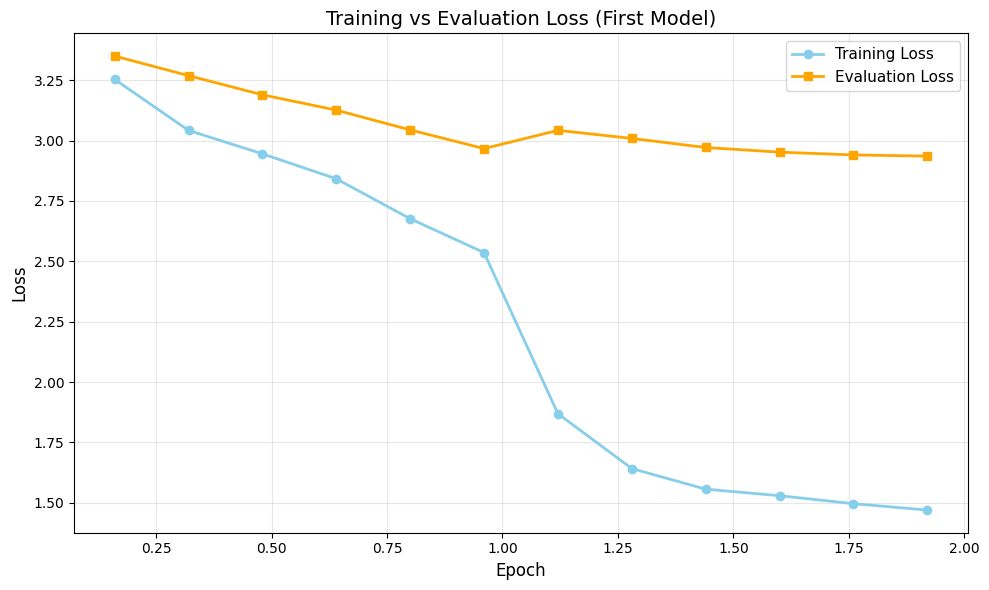

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract training history from the trainer
log_history = trainer.state.log_history

# Lists to store the data
epochs = []
train_losses = []
eval_losses = []

# Plot function
def plot_loss_history(log_history, title):
    """
    Args:
        log_history (list): A list of dictionaries containing the training log.
        title (str): The title for the plot.
    """
    train_epochs = []
    train_losses = []
    eval_epochs = []
    eval_losses = []

    for log_entry in log_history:
        if 'loss' in log_entry and 'learning_rate' in log_entry:
            train_epochs.append(log_entry['epoch'])
            train_losses.append(log_entry['loss'])
        elif 'eval_loss' in log_entry:
            eval_epochs.append(log_entry['epoch'])
            eval_losses.append(log_entry['eval_loss'])

    plt.figure(figsize=(10, 6))
    plt.plot(train_epochs, train_losses, 'o-', color='skyblue', label='Training Loss', linewidth=2, markersize=6)
    plt.plot(eval_epochs, eval_losses, 's-', color='orange', label='Evaluation Loss', linewidth=2, markersize=6)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_loss_history(trainer.state.log_history, 'Training vs Evaluation Loss (First Model)')

Our first model show warning signs and typical indicators of overfitting.

The evaluation loss does reduce during training but by a minimal amount (from 3.35 to 2.93) and is quite a poor performance given the sample amount. This is also a significantly slower reduction than the training loss (from 3.25 to 1.47) meaning the model is heavily overfitting and learning the training data too well. Thus, for the 2nd model run we change the tuning parameters.

## 2nd model w. SmolLM2-135M

* Train SmolLM2-135M (2nd model)
* Remember to reload the dataset and model when training again, otherwise it will likely cache the previous results

* In this run the following adjustments are done:
  * Increase the batch_size to 16 (reducing the training steps)
  * Slightly reducing the learning rate to 3e-5 (more stable learning)
  * Slightly increase the num_train_epochs to 3 (model sees the examples a few more times)


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "assignment2_SmolLM2-135M_2nd",
    push_to_hub=True,
    per_device_train_batch_size=16,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=3e-5,
    num_train_epochs=3,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    report_to="none" # Adding this to avoid setup wandb
)

* Use 10.000 samples for robust performance

In [ ]:
from transformers import Trainer

trainer2 = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"].shuffle(seed=(42)).select(range(10000)),
    eval_dataset=tokenized_datasets["test"],
)

/tmp/ipython-input-4019982731.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer2 = Trainer(


In [ ]:
trainer2.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 0}.


Step,Training Loss,Validation Loss
200,3.051600,2.960070
400,2.808700,2.841698
600,2.686200,2.773933
800,2.472500,2.747335
1000,2.438100,2.722743
1200,2.434900,2.705399
1400,2.333900,2.706909
1600,2.285800,2.705265
1800,2.314700,2.703760


TrainOutput(global_step=1875, training_loss=2.528120076497396, metrics={'train_runtime': 410.0687, 'train_samples_per_second': 73.158, 'train_steps_per_second': 4.572, 'total_flos': 2173799525492736.0, 'train_loss': 2.528120076497396, 'epoch': 3.0})

* Plot training and evaluation loss

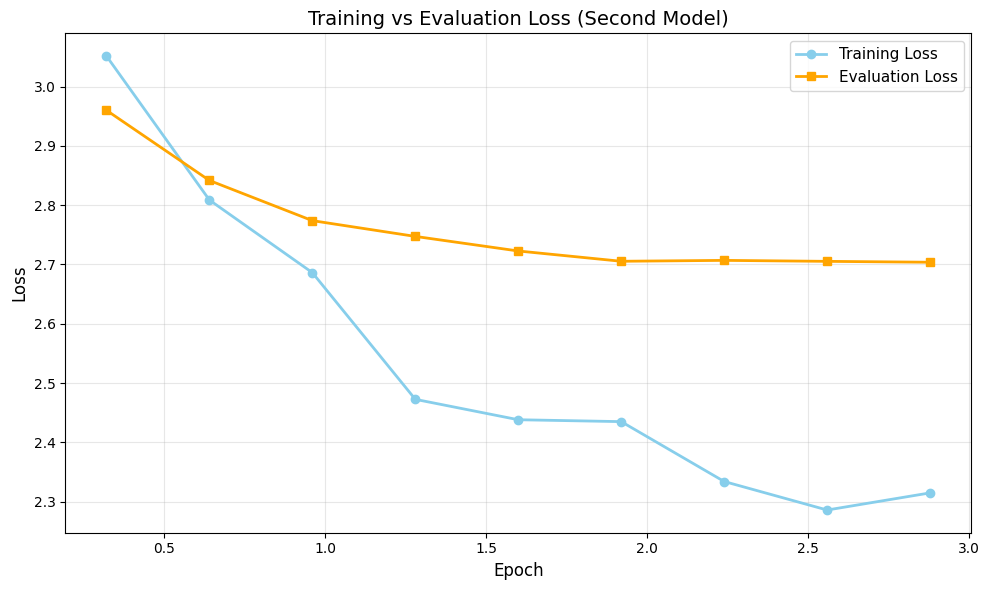

In [ ]:
plot_loss_history(trainer2.state.log_history, 'Training vs Evaluation Loss (Second Model)')

* The tweaked tuning parameters for the second model run are as follows: Increasing the batch size from 8 to 16 to reduce the amount of training steps. Slightly reduce the learning rate to get gentler parameter updates and have more stable learning. Increase the number of training epochs slightly from 2 to 3, so the model sees the examples three times and gets a bit more time to learn from the data.  

* From the plot of the second run, we notice that the model is still not optimal and doesn’t have all the healthy patterns that we are looking for. However, the curves have gotten a bit more stable, they move together more closely and the performance has gotten better overall. After adjusting the tuning parameters, we manage to improve the validation loss down to 2.7. Additionally, while the training loss is still overfitting, it is not as extreme as in the first model and the gap between the validation and training is smaller.  


# Assignment 3
Evaluate HuggingFaceTB/SmolLM-135M-Instruct on the cnn_dailymail dataset used in Chapter 6 in Natural Language Processing with Transformers.

Compare four different experiments each with a different prompting and decoding strategy. Argue for why these are the most promising ones to try. Evaluate the rouge scores of each model on the test set (if compute becomes a problem use a smaller subset of the test set) and compare to the performance of PEGASUS.

## Prerequisites

In [ ]:
!pip install evaluate
!pip install rouge_score
!pip install datasets==3.6.0

import evaluate
import pandas as pd
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=9a68d080547ceaba352febd2bdcb2e7cae3c1671f7c95cc22c802c3e84e470e4
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 38.9 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


* Load cnn_dailymail dataset (300.000 pairs of news articles and summaries)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0")

README.md: 0.00B [00:00, ?B/s]

cnn_dailymail.py: 0.00B [00:00, ?B/s]

The repository for ccdv/cnn_dailymail contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/cnn_dailymail.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


cnn_stories.tgz:   0%|          | 0.00/159M [00:00<?, ?B/s]

dailymail_stories.tgz:   0%|          | 0.00/376M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

* Dictionary to collect summaries

In [ ]:
sample_text = dataset["train"][1]["article"][:2000]
summaries = {}

* Setup NLTK sentence tokenizer

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

* Load SmolLM-135M

In [ ]:
from transformers import pipeline, set_seed
pipe = pipeline("text-generation", model="HuggingFaceTB/SmolLM-135M-Instruct")

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

Device set to use cuda:0


## Experiments
For parameter documentation: https://huggingface.co/docs/transformers/main_classes/text_generation

Each experiment features a different query and decoding strategy.

* Parameters
  * do_sample: True (use random sampling, otherwise greedy decoding)
  * top_k : Looks at K most probable tokens
  * top_p : Considers tokens whose cumulative probability reaches p.
    * Closer to 1 = Output is more random.
    * Closer to 0 = Output is more deterministic.
  * temperature: Randomness of the sampling
    * Closer to 2 = High randomness
    * Closer to 1 = Neutral
    * Closer to 0.1 = Very focused and confident

* Experiment 1

In [ ]:
set_seed(42)

query = sample_text + "\nTL;DR:\n"

pipe_out = pipe(
    query,
    max_length=128,
    clean_up_tokenization_spaces=True,
    do_sample=True,
    temperature=1,
    top_k = 50,
    top_p=0.9
)

summaries["Experiment1"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(query):]))

print(summaries["Experiment1"])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


year-old Brazilian Manzana also claimed his fourth gold in the world title, beating his teammate Michael Fretsurfer by two seconds.
**The 100m/4x100m relay**:

(Olympic athletes have won four gold medals since 2016, including Michael Phelps, who won gold in 2008 and 2012.
The last gold was won by LeBron James after the 2016 Olympics in Atlanta, where he broke his own record of 972 seconds.)
**The 500m/4x400m relay**:

(The 2019 Olympics saw 26 gold medals, and the previous record was won by Kareem Abdul-Jabbar, who also won the 2016 Olympics.)
**The 1000m/4x1000m relay**:

(The 2017 Olympics saw 16 gold medals, and the previous record was won by 2018's Olympic swimmer, who also won the 1000m/4x1000m relay


* Experiment 2

In [ ]:
set_seed(42)

query = "Summarize this article:\n\n" + sample_text + "\n\nSummary:"

pipe_out = pipe(
    query,
    max_length=128,
    clean_up_tokenization_spaces=True,
    do_sample=True,
    temperature=0.9,
    top_k = 75,
    top_p=0.9
)

summaries["Experiment2"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(query):]))

print(summaries["Experiment2"])

Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


 clock and China failed to meet the minimum.
"This is something I've been pushing for years," said Tim Ferriss, a fitness expert and entrepreneur.
"It's a real test of my spirit.
I'm still holding onto that sense of momentum and determination that I was trying to achieve in 2015."
Bolt is a bit of an outcast in the world of world records, with many claiming he's been "burned off" by the 2008 Olympics and 2010 World Championships.
In 2014, Bolt went on a road trip to New York and lost 180,000 miles in just 23 days.
"It's the ultimate test of my energy and my spirit," Bolt said.
"I'm always pushing myself to be the best, and I'm not afraid to do whatever it takes to succeed.
And to me, the best is not just the achievements, but the things that bring me joy and make me feel alive."
Bolt's performance was a major boost to 2015's Olympics, as he finished in second place.
He won at least 14 times in the last two games


* Experiment 3

In [ ]:
set_seed(42)

query = f"Article: {sample_text}\n\nSummarize article in one sentence:\n"

pipe_out = pipe(
    query,
    max_length=128,
    clean_up_tokenization_spaces=True,
    do_sample=True,
    temperature=1,
    top_k = 25,
    top_p=0.9
)

summaries["Experiment3"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(query):]))

print(summaries["Experiment3"])

Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


3rd time Bolt won the gold.
4.
Michael Phelps: As the Olympian, Michael Phelps won the 100-meter gold medal in the men's 4x100m relay, and the 25-meter gold medal in the men's 2x200m.
5.
Terence Ball: As the Olympic swimming champion, Terence Ball won the 100-meter gold medal, and the 200-meter gold medal in the men's 100m freestyle.
6.
Simone Biles: As the Olympic gymnast, Simone Biles won the 100-meter gold medal, and the 25-meter gold medal in the men's 100m freestyle.
7.
Terence Tambour: As the Olympic skier, Terence Tambour won the 100-meter gold medal, and the 25-meter gold medal in the men's cross-country freestyle.
8.
Alvin Chen: As the Olympic swimmer, Alvin Chen won the 100-meter gold medal, and the 25-meter gold medal in the men's


* Experiment 4

In [ ]:
set_seed(42)

query = f"Article: {sample_text}\n\nShort summary of the article: \n:"

pipe_out = pipe(
    query,
    max_length=128,
    clean_up_tokenization_spaces=True,
    do_sample=True,
    temperature=1,
    top_k = 50,
    top_p=0.8
)

summaries["Experiment4"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(query):]))

print(summaries["Experiment4"])

Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


3rd time Bolt won the gold.
4.
Michael Phelps: As the Olympian, Michael Phelps won the 100-meter gold medal in the men's 4x100m relay, and the 25-meter gold medal in the men's 100m butterfly, in his 25th year at the Olympic Games.
5.
Dwayne "The Rock" Johnson: As the NFL's 23rd overall pick, Dwayne "The Rock" Johnson won the 2014 and 2018 MVP awards for his playoff run, where he led the Houston Rock to a 25-36, and led the Chicago Bull to a 12-12 record, beating out the Denver Broncos.
6.
Tarell Altan: As the 25th inductee, Tarell Altan won the 100-meter gold medal in the men's 4x100m relay, and the 25th in the men's 100m butterfly, in his 25th year at the Olympic Games.
7.
Serena Williams: As the World Women


## Comparing the four experiments

In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

EXPERIMENT1
year-old Brazilian Manzana also claimed his fourth gold in the world title, beating his teammate Michael Fretsurfer by two seconds.
**The 100m/4x100m relay**:

(Olympic athletes have won four gold medals since 2016, including Michael Phelps, who won gold in 2008 and 2012.
The last gold was won by LeBron James after the 2016 Olympics in Atlanta, where he broke his own record of 972 seconds.)
**The 500m/4x400m relay**:

(The 2019 Olympics saw 26 gold medals, and the previous record was won by Kareem Abdul-Jabbar, who also won the 2016 Olympics.)
**The 1000m/4x1000m relay**:

(The 2017 Olympics saw 16 gold medals, and the previous record was won by 2018's Olympic swimmer, who also won the 1000m/4x1000m relay

EXPERIMENT2
 clock and China failed to meet the minimum.
"This is something I

## Quality of text from experiments

* Take a small sample of 100 articles from the test set and have each experiment generate a summary for every article.

In [ ]:
rouge_metric = evaluate.load("rouge")
test_subset = dataset["test"].select(range(100))

def generate_summary(article, experiment_name):
    set_seed(42)

    if experiment_name == "EX1":
        query = article + "\nTL;DR:\n"
        pipe_out = pipe(query, max_length=128, clean_up_tokenization_spaces=True,
                       do_sample=True, temperature=1, top_k=50, top_p=0.9)
    elif experiment_name == "EX2":
        query = "Summarize this article:\n\n" + article + "\n\nSummary:"
        pipe_out = pipe(query, max_length=128, clean_up_tokenization_spaces=True,
                       do_sample=True, temperature=0.9, top_k=75, top_p=0.9)
    elif experiment_name == "EX3":
        query = f"Article: {article}\n\nSummarize article in one sentence:\n"
        pipe_out = pipe(query, max_length=128, clean_up_tokenization_spaces=True,
                       do_sample=True, temperature=1, top_k=25, top_p=0.9)
    elif experiment_name == "EX4":
        query = f"Article: {article}\n\nShort summary of the article: \n:"
        pipe_out = pipe(query, max_length=128, clean_up_tokenization_spaces=True,
                       do_sample=True, temperature=1, top_k=50, top_p=0.8)

    return pipe_out[0]["generated_text"][len(query):].strip()

experiment_names = ["EX1", "EX2", "EX3", "EX4"]
all_predictions = {name: [] for name in experiment_names}
all_references = []

for example in tqdm(test_subset):
    article = example["article"][:2000]
    all_references.append(example["highlights"])
    for exp_name in experiment_names:
        all_predictions[exp_name].append(generate_summary(article, exp_name))

results = {}
for exp_name in experiment_names:
    results[exp_name] = rouge_metric.compute(
        predictions=all_predictions[exp_name],
        references=all_references
    )

records = []
for exp_name in experiment_names:
    records.append({
        "rouge1": results[exp_name]["rouge1"],
        "rouge2": results[exp_name]["rouge2"],
        "rougeL": results[exp_name]["rougeL"],
        "rougeLsum": results[exp_name]["rougeLsum"]
    })

results_df = pd.DataFrame.from_records(records, index=experiment_names)
print(results_df.round(6))

  0%|          | 0/100 [00:00<?, ?it/s]Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take 

       rouge1    rouge2    rougeL  rougeLsum
EX1  0.113049  0.015620  0.077518   0.099095
EX2  0.114108  0.019931  0.082250   0.102421
EX3  0.110418  0.015206  0.076432   0.094917
EX4  0.110616  0.018838  0.077187   0.097085


* Higher ROUGE scores are better

## Compare experiments with the performance of Pegasus

In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=8, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

In [ ]:
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

# Define rouge_names here
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

pegasus_score = evaluate_summaries_pegasus(test_subset, rouge_metric,
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, pegasus_score[rn]) for rn in rouge_names) # Access the score directly
pd.DataFrame(rouge_dict, index=["pegasus"])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 13/13 [02:46<00:00, 12.82s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.312891,0.118782,0.220346,0.25987


# Assignment 4

## Prerequisites

In [ ]:
!pip install evaluate
!pip install optuna

import evaluate
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 26.5 MB/s eta 0:00:00


* GPU connect

In [ ]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1st task
Fine-tune answerdotai/ModernBERT-large on the clinc_oos (load_dataset("clinc_oos", "plus")) dataset.
Show the main training results and show the result from giving the model the following query: “Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van”.

* Load clinc_oos dataset

In [ ]:
from datasets import load_dataset
clinc = load_dataset("clinc_oos", "plus")

README.md: 0.00B [00:00, ?B/s]

plus/train-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

plus/validation-00000-of-00001.parquet:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

plus/test-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

* Load ModernBert-Large and tokenize in similar fashion to assignment 1

In [ ]:
from transformers import AutoTokenizer
checkpoint = "answerdotai/ModernBERT-large"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [ ]:
tokenized_datasets = clinc.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'intent', 'input_ids', 'attention_mask'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent', 'input_ids', 'attention_mask'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent', 'input_ids', 'attention_mask'],
        num_rows: 5500
    })
})

15.250 training rows, 3.100 validation rows, 5.500 test rows

* Train ModernBert model
  * Notice that the dataset has 151 labels in total so we set num_labels = 151
  * The labels are set as "intent" so we have to rename them
  * Info on dataset: https://huggingface.co/datasets/clinc/clinc_oos

In [ ]:
from transformers import TrainingArguments, AutoModelForSequenceClassification

num_labels = 151
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels).to(device)

training_args = TrainingArguments(
    "assignment4_ModernBertLarge_clinc",
    push_to_hub=True,
    per_device_train_batch_size=32,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=3e-5,
    num_train_epochs=4,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    report_to="none", # Adding this to avoid setup wandb
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Rename the 'intent' column to 'label'
tokenized_datasets["train"] = tokenized_datasets["train"].rename_column("intent", "label")
tokenized_datasets["validation"] = tokenized_datasets["validation"].rename_column("intent", "label")

* Define evaluation metrics

In [ ]:
accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy and F1 Score
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)
trainer.train()

/tmp/ipython-input-2726608778.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W1019 19:41:40.766000 494 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Step,Training Loss,Validation Loss,Accuracy,F1
200,1.917400,0.371955,0.908065,0.907501
400,0.251100,0.252809,0.948387,0.948086
600,0.106700,0.213813,0.953871,0.953205
800,0.055400,0.195054,0.958065,0.957285
1000,0.048800,0.165580,0.969355,0.968919
1200,0.016300,0.159564,0.972581,0.972188
1400,0.010000,0.166629,0.974194,0.973904
1600,0.003500,0.161353,0.973871,0.973589
1800,0.001300,0.164616,0.972258,0.971970


TrainOutput(global_step=1908, training_loss=0.25300927633571924, metrics={'train_runtime': 1002.8471, 'train_samples_per_second': 60.827, 'train_steps_per_second': 1.903, 'total_flos': 4857360548229984.0, 'train_loss': 0.25300927633571924, 'epoch': 4.0})

In [ ]:
trainer.push_to_hub(commit_message="Completed training")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...e_clinc/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...e_clinc/model.safetensors:   3%|2         | 41.9MB / 1.58GB            

CommitInfo(commit_url='https://huggingface.co/Maziger1/assignment4_ModernBertLarge_clinc/commit/d13d78000f2c53b4014a71aaf549c66096c3e8e3', commit_message='Completed training', commit_description='', oid='d13d78000f2c53b4014a71aaf549c66096c3e8e3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maziger1/assignment4_ModernBertLarge_clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='Maziger1/assignment4_ModernBertLarge_clinc'), pr_revision=None, pr_num=None)

The model has been trained with a val loss of just under 0.16 and an accuracy of approx 97.2%. We can see that the model started overfitting at around step 1200 (where validation loss reached its minimum, afterwards it starts to increase again)

* Load model from huggingface

In [ ]:
from transformers import pipeline

bert_ckpt = "Maziger1/assignment4_ModernBertLarge_clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Device set to use cuda:0


* Evaluate on query

In [ ]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W1021 19:54:02.502000 306 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


[{'label': 'LABEL_40', 'score': 0.9999973773956299}]

Label ID = 40 = car_rental (see Label ID section of: https://huggingface.co/datasets/clinc/clinc_oos)

With an accuracy of = 99.99% means the model is absolutely certain on the predicted labelling.

## 2nd task
Follow the example from Chapter 8 in Natural Language Processing with Transformers and produce a plot where you compare the accuracy, latency and size of 1) your fine-tuned ModernBert-large baseline, 2) a distilled version, 3) a distilled version using Optuna and 4) a quantized-distilled version. Think carefully about the appropriate student model to select.

### Create performance benchmark

In [ ]:
from pathlib import Path
from time import perf_counter
import numpy as np
from sklearn.metrics import accuracy_score

intents = clinc["test"].features["intent"]

In [ ]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="ModernBert baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        self.accuracy_metric = evaluate.load("accuracy")

    def compute_accuracy(self):
        preds, labels = [], []
        for example in self.dataset:
            pred_label_str = self.pipeline(example["text"])[0]["label"]
            # Given format is "Label_XX", we extract the number after "Label_"
            pred_int = int(pred_label_str.split('_')[1])
            label = example["intent"]
            preds.append(pred_int)
            labels.append(label)
        accuracy = self.accuracy_metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_pipeline(self):
        latencies = []
        # Warmup
        for _ in range(10):
            _ = self.pipeline(query)
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

<>:46: SyntaxWarning: invalid escape sequence '\-'
<>:46: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipython-input-1284484340.py:46: SyntaxWarning: invalid escape sequence '\-'
  print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")


In [ ]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 1510.63


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Average latency (ms) - 33.48 +\- 1.33
Accuracy on test set - 0.914


### Distilled version

In [ ]:
from transformers import TrainingArguments
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None): # Add num_items_in_batch
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

* Pre-trained model for the student
  * We need a smaller model for the student
  * "Knowledge distillation works best when the teacher and student are of the same model"
  * Given the above information and that we are currently applying a ModernBert-large model, we can make use of ModernBert-base (https://huggingface.co/answerdotai/ModernBERT-base). It has the same familiar architecture, but with fewer parameters, making it suitable as a student.

In [ ]:
from transformers import AutoTokenizer

student_ckpt = "answerdotai/ModernBert-base"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [ ]:
import evaluate # Import the evaluate library

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_metric = evaluate.load("accuracy")
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
batch_size = 48

student_training_args = DistillationTrainingArguments(
    output_dir="assignment4_ModernBertBase_distilled_clinc",
    eval_strategy = "epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    alpha=1,
    weight_decay=0.01,
    push_to_hub=True,
    report_to="none", # Adding this to avoid setup wandb
    )

In [ ]:
from transformers import AutoConfig

id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

num_labels = 151
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

config.json: 0.00B [00:00, ?B/s]

In [ ]:
teacher_ckpt = "Maziger1/assignment4_ModernBertLarge_clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [ ]:
modernbert_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=clinc_enc['train'],
    eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer)

modernbert_trainer.train()

/tmp/ipython-input-2687327614.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You sh

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.428307,0.898387
2,1.173600,0.283286,0.931935
3,1.173600,0.228814,0.944516
4,0.048000,0.219776,0.943548
5,0.004800,0.219747,0.944194


TrainOutput(global_step=1590, training_loss=0.3858147088930292, metrics={'train_runtime': 1347.7219, 'train_samples_per_second': 56.577, 'train_steps_per_second': 1.18, 'total_flos': 1126084858116036.0, 'train_loss': 0.3858147088930292, 'epoch': 5.0})

In [ ]:
modernbert_trainer.push_to_hub("Completed training")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...d_clinc/training_args.bin: 100%|##########| 5.91kB / 5.91kB            

  ...988367.c1bc91b2164c.408.0: 100%|##########| 12.2kB / 12.2kB            

  ...d_clinc/model.safetensors:   6%|5         | 33.6MB /  599MB            

CommitInfo(commit_url='https://huggingface.co/Maziger1/assignment4_ModernBertBase_distilled_clinc/commit/e02c00511bb28b04085f43ba1ecdc4c786a0286f', commit_message='Completed training', commit_description='', oid='e02c00511bb28b04085f43ba1ecdc4c786a0286f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maziger1/assignment4_ModernBertBase_distilled_clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='Maziger1/assignment4_ModernBertBase_distilled_clinc'), pr_revision=None, pr_num=None)

The model has been trained with a val loss of 0.219 and an accuracy of approx 94.4%.

In [ ]:
finetuned_ckpt = "Maziger1/assignment4_ModernBertBase_distilled_clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)
optim_type="ModernBERT-base-distilled"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Device set to use cuda:0


Model size (MB) - 571.19
Average latency (ms) - 26.64 +\- 1.15
Accuracy on test set - 0.907


We notice the size of the model went from 1510 MB to 571 MB. In return, the accuracy decreased a bit from 0.914 to 0.907.

### Distilled version using Optuna

* Optuna uses Bayesian optimisation to narrow down the search space
* It finds better values for a and T
* So by picking random values within the hyperparameter search space and training the student model with these hyperparameters. The performance is evaluated on the validation set. Then we use optuna's algorithm to select new combinations based on previous results. Lastly, the best combinations are found.

* Add hyperparameter search space

In [ ]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

* Training configurations

In [ ]:
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
student_training_args.log_level = 40

* Hyperparameter search

In [ ]:
best_run = modernbert_trainer.hyperparameter_search(
    n_trials=5, direction="maximize", hp_space=hp_space)

[I 2025-10-21 18:33:45,625] A new study created in memory with name: no-name-01b2b6d4-ef5f-41c9-9015-cead6555467a
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.570800,1.885974,0.871935
2,1.348300,1.054025,0.940000
3,0.805000,0.816127,0.945161
4,0.612200,0.719158,0.949677
5,0.524600,0.673607,0.954839
6,0.483300,0.660751,0.953871


[I 2025-10-21 18:43:37,800] Trial 0 finished with value: 0.9538709677419355 and parameters: {'num_train_epochs': 6, 'alpha': 0.30644514172774995, 'temperature': 11}. Best is trial 0 with value: 0.9538709677419355.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.437100,1.770249,0.890323
2,1.265400,1.011009,0.943871
3,0.772900,0.799914,0.955161
4,0.605500,0.718549,0.955484
5,0.537900,0.696224,0.958710


[I 2025-10-21 18:52:00,589] Trial 1 finished with value: 0.9587096774193549 and parameters: {'num_train_epochs': 5, 'alpha': 0.10661815115158002, 'temperature': 11}. Best is trial 1 with value: 0.9587096774193549.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.791100,1.683408,0.856774
2,1.200900,0.936029,0.942258
3,0.714300,0.719118,0.955484
4,0.542900,0.626978,0.957742
5,0.461100,0.585837,0.960323
6,0.417700,0.562658,0.960323
7,0.391400,0.548504,0.959677
8,0.375000,0.543948,0.961290


[I 2025-10-21 19:05:00,020] Trial 2 finished with value: 0.9612903225806452 and parameters: {'num_train_epochs': 8, 'alpha': 0.1346368700031958, 'temperature': 20}. Best is trial 2 with value: 0.9612903225806452.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,8.136700,3.043430,0.878710
2,2.097400,1.454980,0.940000
3,1.094900,1.034773,0.957742
4,0.752400,0.867245,0.958387
5,0.590600,0.772694,0.960000
6,0.505200,0.731240,0.959355
7,0.457300,0.703007,0.961290
8,0.429700,0.694824,0.960000


[I 2025-10-21 19:18:07,140] Trial 3 finished with value: 0.96 and parameters: {'num_train_epochs': 8, 'alpha': 0.24184024399469806, 'temperature': 5}. Best is trial 2 with value: 0.9612903225806452.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,4.153800,1.950207,0.890645
2,1.368700,1.022099,0.944516
3,0.780000,0.775335,0.958065
4,0.580800,0.670095,0.959677
5,0.488800,0.619959,0.960323
6,0.438800,0.596678,0.961935
7,0.409100,0.578877,0.962258
8,0.390700,0.572552,0.962258


[I 2025-10-21 19:31:21,402] Trial 4 finished with value: 0.962258064516129 and parameters: {'num_train_epochs': 8, 'alpha': 0.43538880994701323, 'temperature': 9}. Best is trial 4 with value: 0.962258064516129.


In [ ]:
print(best_run)

BestRun(run_id='4', objective=0.962258064516129, hyperparameters={'num_train_epochs': 8, 'alpha': 0.43538880994701323, 'temperature': 9}, run_summary=None)


* Run model with the parameters from best_run

In [ ]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

# Define a new repository to store our distilled model
distilled_ckpt = "assignment4_ModernBert_distilled_clinc_optuna"
student_training_args.output_dir = distilled_ckpt
student_training_args.log_level = "error"

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=clinc_enc['train'],
    eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer)

distil_trainer.train();

/tmp/ipython-input-2687327614.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,3.218300,1.452463,0.916774
2,0.978900,0.799389,0.951935
3,0.530300,0.576838,0.961613
4,0.368400,0.496884,0.961935
5,0.297000,0.454666,0.962581
6,0.260200,0.435381,0.964839
7,0.239600,0.424157,0.963871
8,0.227700,0.420624,0.964839


In [ ]:
distil_trainer.push_to_hub("Completed training")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._optuna/training_args.bin: 100%|##########| 5.91kB / 5.91kB            

  ..._optuna/model.safetensors:   7%|7         | 41.9MB /  599MB            

CommitInfo(commit_url='https://huggingface.co/Maziger1/assignment4_ModernBert_distilled_clinc_optuna/commit/dc355c72888d110d4ba69570fbb0869474d28767', commit_message='Completed training', commit_description='', oid='dc355c72888d110d4ba69570fbb0869474d28767', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maziger1/assignment4_ModernBert_distilled_clinc_optuna', endpoint='https://huggingface.co', repo_type='model', repo_id='Maziger1/assignment4_ModernBert_distilled_clinc_optuna'), pr_revision=None, pr_num=None)

* Benchmarking distilled optuna model

In [ ]:
distilled_ckpt = "Maziger1/assignment4_ModernBert_distilled_clinc_optuna"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "ModernBERT-distilled-optuna"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Device set to use cuda:0


Model size (MB) - 571.19
Average latency (ms) - 26.39 +\- 0.48
Accuracy on test set - 0.906


### Distilled version using quantisation

In [ ]:
from torch.quantization import quantize_dynamic

model_ckpt = "Maziger1/assignment4_ModernBert_distilled_clinc_optuna"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

/tmp/ipython-input-2608930489.py:8: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)


* Benchmarking distilled quantisation model

In [ ]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer, device="cpu")
optim_type = "ModernBERT-distilled-quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Device set to use cpu
Compiling the model with `torch.compile` and using a `torch.cpu` device is not supported. Falling back to non-compiled mode.


Model size (MB) - 253.67
Average latency (ms) - 37.72 +\- 1.09
Accuracy on test set - 0.801


### Plot ModernBert-large baseline, distilled version, distilled version w. optuna and distilled version w. quantisation

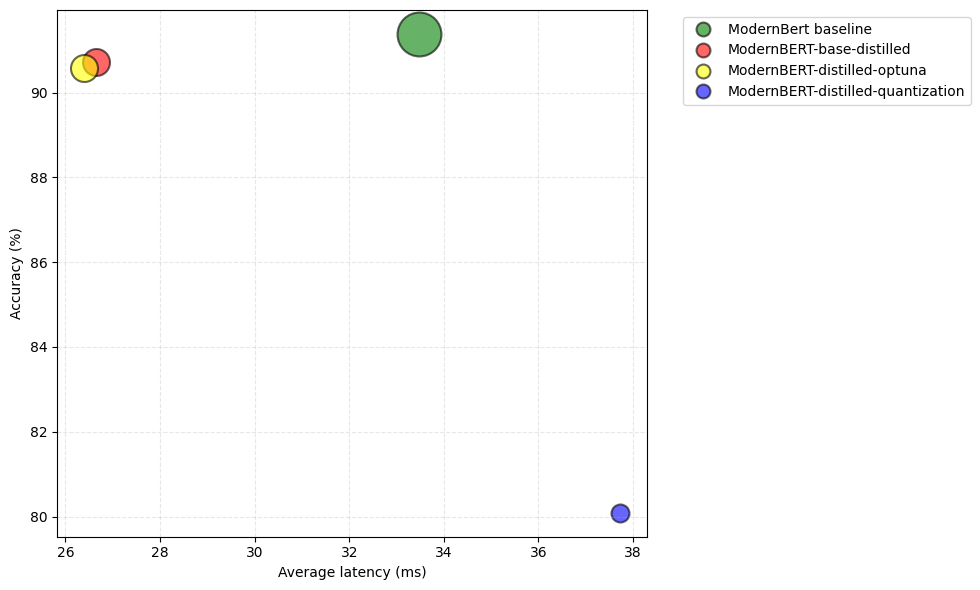

Model                                    Latency (ms)    Accuracy (%)    Size (MB)      
ModernBert baseline                      33.48           91.38           1510.63        
ModernBERT-base-distilled                26.64           90.73           571.19         
ModernBERT-distilled-optuna              26.39           90.58           571.19         
ModernBERT-distilled-quantization        37.72           80.09           253.67         


In [ ]:
import matplotlib.pyplot as plt

model_names = list(perf_metrics.keys())
latencies = [perf_metrics[name]["time_avg_ms"] for name in model_names]
accuracies = [perf_metrics[name]["accuracy"] * 100 for name in model_names]
sizes = [perf_metrics[name]["size_mb"] for name in model_names]

size_scale = 1000
bubble_sizes = [size * size_scale / max(sizes) for size in sizes]

colors = ['Green', 'Red', 'Yellow', 'Blue']

fig, ax = plt.subplots(figsize=(10, 6))
for i, name in enumerate(model_names):
    ax.scatter(latencies[i], accuracies[i], s=bubble_sizes[i],
               c=[colors[i]], alpha=0.6, edgecolors='black', linewidth=1.5,
               label=name)

ax.set_xlabel('Average latency (ms)')
ax.set_ylabel('Accuracy (%)')

ax.grid(True, alpha=0.3, linestyle='--')

legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=colors[i], markersize=10,
                             alpha=0.6, markeredgecolor='black', markeredgewidth=1.5,
                             label=name)
                  for i, name in enumerate(model_names)]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1),
          loc='upper left', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

print(f"{'Model':<40} {'Latency (ms)':<15} {'Accuracy (%)':<15} {'Size (MB)':<15}")
for name in model_names:
    print(f"{name:<40} {perf_metrics[name]['time_avg_ms']:<15.2f} "
          f"{perf_metrics[name]['accuracy']*100:<15.2f} {perf_metrics[name]['size_mb']:<15.2f}")

# Assignment 5
With point of departure in Chapter 6 in Hands-on Generative AI with Transformers and Diffusion Models, carefully fine-tune mistralai/Mistral-7B-v0.3 while manipulating key hyperparameters. For your best model, present the training-validation plot and completions for the prompts below:

prompts = [ "What is the capital of Germany? Explain why thats the case and if it was different in the past?", "Write a Python function to calculate the factorial of a number.", "A rectangular garden has a length of 25 feet and a width of 15 feet. If you want to build a fence around the entire garden, how many feet of fencing will you need?", "What is the difference between a fruit and a vegetable? Give examples of each.", ]

### Prerequisites

In [1]:
!pip install -U bitsandbytes trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 40.3 MB/s eta 0:00:00


In [2]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Fine-tuning Mistral

* Let us try to use bfloat16 as target precision, since qint8 in the previous assignment had issues with accuracy
* Also use nf4 instead of standard fp4, this should be a good standard to use a and usually more optimal
* Double quantisation is applied to hopefully save more memory

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    )

model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.3",
    quantization_config=quantization_config,
    device_map="auto")

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

* We lower the learning rate to 2e-4 for more stability
* Adjust to steps strategy
* Set num_train_epochs to 3
* Add warmup_ratio to see if we can remove some noise from the beginning of training
* Adjust weight_decay to 0.05

In [10]:
from trl import SFTConfig, SFTTrainer
from datasets import load_dataset
from peft import LoraConfig

dataset = load_dataset("timdettmers/openassistant-guanaco", split="train")
dataset_eval = load_dataset("timdettmers/openassistant-guanaco", split="test")

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

sft_config = SFTConfig(
    "assignment5_Mistral7B_finetuning",
    push_to_hub=True,
    per_device_train_batch_size=8,
    weight_decay=0.05,
    lr_scheduler_type="cosine",
    learning_rate=2e-4,
    warmup_ratio=0.03,
    num_train_epochs=3,
    eval_strategy="steps",
    eval_steps=30,
    logging_steps=30,
    gradient_checkpointing=True,
    max_length=512,
    dataset_text_field="text",
    packing=True,
    report_to="none", # Adding this to avoid setup wandb
)

trainer = SFTTrainer(
    model,
    args=sft_config,
    train_dataset=dataset.select(range(800)),
    eval_dataset=dataset_eval.select(range(100)),
    peft_config=peft_config,
)

trainer.train()

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


Adding EOS to train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
30,1.191400,1.083063,1.155907,121332.000000,0.724123
60,1.131100,1.058124,1.104062,242641.000000,0.730185
90,1.099400,1.059942,1.079646,362489.000000,0.730250
120,1.054600,1.061405,1.079174,484097.000000,0.729802
150,1.020900,1.065206,1.036256,603794.000000,0.728842
180,0.999400,1.066759,1.039566,725281.000000,0.728950


TrainOutput(global_step=201, training_loss=1.0771605458425646, metrics={'train_runtime': 445.4762, 'train_samples_per_second': 3.589, 'train_steps_per_second': 0.451, 'total_flos': 3.453469943839949e+16, 'train_loss': 1.0771605458425646, 'entropy': 1.0835934423265003, 'num_tokens': 808713.0, 'mean_token_accuracy': 0.7338815416608538, 'epoch': 3.0})

In [12]:
trainer.push_to_hub(commit_message="Completed training")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...etuning/training_args.bin: 100%|##########| 6.22kB / 6.22kB            

  ...inetuning/tokenizer.model: 100%|##########|  587kB /  587kB            

  ...adapter_model.safetensors: 100%|##########| 13.6MB / 13.6MB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Maziger1/assignment5_Mistral7B_finetuning/commit/5d2640da0116da409b2f2b9c56a1b6a48bed359c', commit_message='Completed training', commit_description='', oid='5d2640da0116da409b2f2b9c56a1b6a48bed359c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maziger1/assignment5_Mistral7B_finetuning', endpoint='https://huggingface.co', repo_type='model', repo_id='Maziger1/assignment5_Mistral7B_finetuning'), pr_revision=None, pr_num=None)

## Training-validation plot

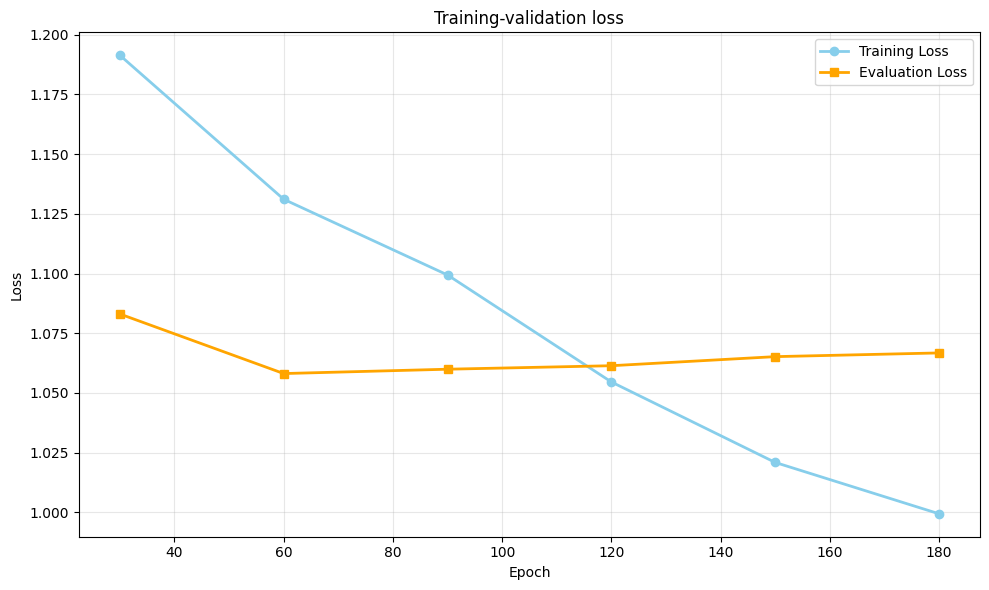

In [11]:
import matplotlib.pyplot as plt

def plot_loss_history(log_history, title):
    """
    Args:
        log_history (list): A list of dictionaries containing the training log.
        title (str): The title for the plot.
    """
    train_steps = []
    train_losses = []
    eval_steps = []
    eval_losses = []

    for log_entry in log_history:
        if 'loss' in log_entry and 'step' in log_entry:
            train_steps.append(log_entry['step'])
            train_losses.append(log_entry['loss'])
        elif 'eval_loss' in log_entry and 'step' in log_entry:
            eval_steps.append(log_entry['step'])
            eval_losses.append(log_entry['eval_loss'])

    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_losses, 'o-', color='skyblue', label='Training Loss', linewidth=2, markersize=6)
    plt.plot(eval_steps, eval_losses, 's-', color='orange', label='Evaluation Loss', linewidth=2, markersize=6)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_loss_history(trainer.state.log_history, 'Training-validation loss')

## Testing model with prompts

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.3")
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.3",
    torch_dtype=torch.float16,
    device_map=device,
)

# Load fine-tuned model as adapter
model.load_adapter("Maziger1/assignment5_Mistral7B_finetuning")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/859 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [5]:
import textwrap

pipe = pipeline("text-generation",
                model=model,
                tokenizer=tokenizer,
                pad_token_id=tokenizer.eos_token_id)

prompts = [
    "What is the capital of Germany? Explain why thats the case and if it was different in the past?",
    "Write a Python function to calculate the factorial of a number.",
    "A rectangular garden has a length of 25 feet and a width of 15 feet. If you want to build a fence around the entire garden, how many feet of fencing will you need?",
    "What is the difference between a fruit and a vegetable? Give examples of each."
]

for prompt in prompts:
    print(f"\n{'─'*80}")
    wrapped_prompt = textwrap.fill(prompt, width=75, initial_indent="Prompt: ", subsequent_indent="        ")
    print(wrapped_prompt)
    print(f"{'─'*80}")
    response = pipe(prompt,
                    max_new_tokens=128,
                    temperature=0.9,
                    pad_token_id=tokenizer.eos_token_id
                    )[0]["generated_text"]
    answer = response[len(prompt):].strip()
    wrapped_answer = textwrap.fill(answer, width=75, initial_indent="  ", subsequent_indent="  ")
    print(wrapped_answer)

Device set to use cuda



────────────────────────────────────────────────────────────────────────────────
Prompt: What is the capital of Germany? Explain why thats the case and if
        it was different in the past?
────────────────────────────────────────────────────────────────────────────────
  Berlin is the capital of Germany. It became the capital in 1990. Before
  that it was Bonn, and before that it was the city of King Karl in 1871.
  It was chosen as the capital because it was the middle point between the
  North and South of Germany, and in the middle of the Rhine and Danube.

────────────────────────────────────────────────────────────────────────────────
Prompt: Write a Python function to calculate the factorial of a number.
────────────────────────────────────────────────────────────────────────────────
  My solution:  def factorial(x):   if x < 0:     return x   else:     if x
  == 0:       return 1     else:       return x*factorial(x-1)  print
  factorial(1) print factorial(5) print factoria

In [8]:
def factorial(x):
    if x < 0:
        return x
    else:
        if x == 0:
            return 1
        else:
            return x * factorial(x - 1)

print(factorial(1))
print(factorial(5))
print(factorial(-1))
print(factorial(0))

1
120
-1
1


# Assignment 6
With point of departure in the Optimizing RAG notebook improve on the baseline performance of the RAG pipeline. Report accuracy and latency for three selected experiments and reflect on your results.

## Prerequisites

In [1]:
!pip install -q pypdf langchain-community sentence-transformers transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.1/467.1 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.1 which is incompatible.
langchain 0.3.27 requires langchain-text-splitters<1.0.0,>=0.3.9, but you have langchain-text-splitters 1.0.0 which is incompatible.


In [2]:
import os
import pandas as pd
from huggingface_hub import hf_hub_download
from pathlib import Path
import re
import time
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer, util, CrossEncoder
import torch
from transformers import pipeline

## Base functions

In [3]:
def download_documents(document_name="GoldmanSachs", cache_dir="./haystack_data"):
    """
    Download PDFs and metadata from the Document Haystack dataset.

    Args:
        document_name: Name of document to download (e.g., "GoldmanSachs", "AIG", "AmericanAirlines")
                      Or "all" to download all available documents
        cache_dir: Local directory to store downloaded files

    Returns:
        Path to the base directory containing downloaded documents
    """
    # Available documents in the dataset
    all_documents = [
        "GoldmanSachs", "AIG", "AmericanAirlines", "APA", "BankOfMontreal",
        "BristolMyers", "CVS", "Chevron", "Cigna", "Chubb", "Comcast",
        "ConocoPhillips", "Disney", "ExxonMobil", "FedEx", "Ford",
        "GeneralMotors", "HCA", "JPMorgan", "JohnsonJohnson", "Lowes",
        "MetLife", "Progressive", "Tesla", "UnitedHealth"
    ]

    if document_name == "all":
        documents_to_download = all_documents
    else:
        if document_name not in all_documents:
            print(f"Warning: {document_name} not in known documents. Attempting anyway...")
        documents_to_download = [document_name]

    page_lengths = [5, 10, 25, 50, 75, 100, 150, 200]
    base_path = Path(cache_dir)
    base_path.mkdir(exist_ok=True)

    print(f"Downloading documents: {', '.join(documents_to_download)}")
    print("="*70)

    for doc_name in documents_to_download:
        print(f"\n📄 Downloading {doc_name}...")

        for pages in page_lengths:
            folder_name = f"{doc_name}_{pages}Pages"

            try:
                # Download PDF with text needles
                hf_hub_download(
                    repo_id="AmazonScience/document-haystack",
                    repo_type="dataset",
                    filename=f"{doc_name}/{folder_name}/{doc_name}_{pages}Pages_TextNeedles.pdf",
                    local_dir=str(base_path),
                    local_dir_use_symlinks=False
                )

                # Download needles.csv
                hf_hub_download(
                    repo_id="AmazonScience/document-haystack",
                    repo_type="dataset",
                    filename=f"{doc_name}/{folder_name}/needles.csv",
                    local_dir=str(base_path),
                    local_dir_use_symlinks=False
                )

                # Download prompt_questions.txt
                hf_hub_download(
                    repo_id="AmazonScience/document-haystack",
                    repo_type="dataset",
                    filename=f"{doc_name}/{folder_name}/prompt_questions.txt",
                    local_dir=str(base_path),
                    local_dir_use_symlinks=False
                )

            except Exception as e:
                print(f"   ✗ Error downloading {pages}-page document: {e}")

        print(f"   ✓ {doc_name} downloaded")

    return base_path

In [4]:
def load_test_cases(base_path, document_name="GoldmanSachs"):
    """
    Load test cases from downloaded documents.
    """
    test_cases = []
    page_lengths = [5, 10, 25, 50, 75, 100, 150, 200]

    print(f"Looking for documents in: {base_path}")

    # The files are in base_path/DocumentName/DocumentName_XPages/

    doc_base = base_path / document_name

    if not doc_base.exists():
        print(f"ERROR: Document folder not found at {doc_base}")
        print(f"Available folders: {list(base_path.iterdir())}")
        return test_cases

    print(f"\nProcessing {document_name}...")

    for pages in page_lengths:
        folder_name = f"{document_name}_{pages}Pages"
        folder_path = doc_base / folder_name

        if not folder_path.exists():
            continue

        pdf_path = folder_path / f"{document_name}_{pages}Pages_TextNeedles.pdf"
        needles_csv_path = folder_path / "needles.csv"
        prompts_path = folder_path / "prompt_questions.txt"

        if not pdf_path.exists() or not needles_csv_path.exists():
            print(f"  ✗ Missing files in {folder_path}")
            continue

        print(f"  ✓ Loading {pages}-page document...")

        # Load PDF
        loader = PyPDFLoader(str(pdf_path))
        docs = loader.load()
        full_document = "\n\n".join([doc.page_content for doc in docs])

        # Read needles and prompts
        needles_df = pd.read_csv(needles_csv_path, header=None, names=["needle_text"])
        with open(prompts_path, 'r') as f:
            prompts = [line.strip() for line in f.readlines() if line.strip()]

        # Extract expected answers
        for idx, needle in enumerate(needles_df["needle_text"]):
            match = re.search(r'The secret (.+?) is ["\']?(.+?)["\']?\.?$', needle)
            if match and idx < len(prompts):
                key = match.group(1)
                value = match.group(2).strip('."\'')

                test_cases.append({
                    "document_name": document_name,
                    "document_length": pages,
                    "needle": needle,
                    "key": key,
                    "expected_value": value,
                    "prompt": prompts[idx],
                    "full_document": full_document
                })

        print(f"    Added {len(needles_df)} test cases")

    print(f"\n✓ Total test cases loaded: {len(test_cases)}")
    return test_cases

## RAG components

In [5]:
class Chunker:
    """Handles document chunking - easily swappable"""

    def __init__(self, chunk_size=500, chunk_overlap=100):
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap
        )

    def chunk(self, document_text):
        """Split document into chunks"""
        return self.splitter.split_text(document_text)

In [6]:
class Embedder:
    """Handles embedding - easily swappable"""

    def __init__(self, model_name="BAAI/bge-small-en-v1.5"):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)

    def embed(self, texts):
        """Embed texts into vectors"""
        return self.model.encode(texts, convert_to_tensor=True)

In [7]:
class Retriever:
    """Handles retrieval - easily swappable"""

    def __init__(self, embedder):
        self.embedder = embedder

    def retrieve(self, query, chunks, chunk_embeddings, top_k=5):
        """Retrieve top-k most relevant chunks"""
        query_embedding = self.embedder.embed(query)
        similarities = util.pytorch_cos_sim(query_embedding, chunk_embeddings)

        # Handle case where top_k is larger than number of chunks
        actual_k = min(top_k, len(chunks))
        top_k_indices = similarities[0].topk(actual_k).indices
        return [chunks[i] for i in top_k_indices]

In [8]:
class Reranker:
    """Handles reranking of retrieved chunks - optional component"""

    def __init__(self, model_name='cross-encoder/ms-marco-MiniLM-L-6-v2'):
        """
        Initialize reranker with a cross-encoder model.

        Args:
            model_name: HuggingFace model name for cross-encoder
                       Popular options:
                       - 'cross-encoder/ms-marco-MiniLM-L-6-v2' (fast, good)
                       - 'BAAI/bge-reranker-base' (high quality, decent size)
        """
        self.model_name = model_name
        self.model = CrossEncoder(model_name)

    def rerank(self, query, chunks, top_k=None):
        """
        Rerank chunks based on query-chunk relevance scores.

        Args:
            query: Search query
            chunks: List of text chunks to rerank
            top_k: Return only top_k after reranking (None = return all)

        Returns:
            List of reranked chunks
        """
        # Create pairs of [query, chunk] for cross-encoder
        pairs = [[query, chunk] for chunk in chunks]

        # Get relevance scores
        scores = self.model.predict(pairs)

        # Sort chunks by score (descending)
        ranked_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
        reranked_chunks = [chunks[i] for i in ranked_indices]

        # Return top_k if specified
        if top_k:
            return reranked_chunks[:top_k]
        return reranked_chunks


In [9]:
class Generator:
    """Handles answer generation - easily swappable"""

    def __init__(self, model_name="HuggingFaceTB/SmolLM-135M-Instruct"):
        device = 0 if torch.cuda.is_available() else -1
        self.pipeline = pipeline(
            "text-generation",
            model=model_name,
            device=device
        )
        self.system_prompt = (
            "You are a helpful assistant that answers questions based on the given context. "
            "Provide direct, concise answers."
        )

    def generate(self, query, context_chunks):
        """Generate answer from query and context"""
        context = "\n".join(context_chunks)
        prompt = f"Context:\n{context}\n\nQuestion: {query}\nAnswer:"

        messages = [
            {"role": "system", "content": self.system_prompt},
            {"role": "user", "content": prompt},
        ]

        response = self.pipeline(messages, max_new_tokens=100)
        return response[0]["generated_text"][-1]["content"]

In [10]:
class RAGPipeline:
    """Complete RAG pipeline - compose all components"""

    def __init__(self, chunker, embedder, retriever, generator, reranker=None):
        """
        Initialize RAG pipeline.

        Args:
            chunker: Chunker instance
            embedder: Embedder instance
            retriever: Retriever instance
            generator: Generator instance
            reranker: Optional Reranker instance (None = no reranking)
        """
        self.chunker = chunker
        self.embedder = embedder
        self.retriever = retriever
        self.generator = generator
        self.reranker = reranker

    def prepare_document(self, document_text):
        """Prepare document for retrieval"""
        chunks = self.chunker.chunk(document_text)
        embeddings = self.embedder.embed(chunks)
        return chunks, embeddings

    def query(self, query, chunks, chunk_embeddings, top_k=5, rerank_top_k=None):
        """
        Run full RAG pipeline with optional reranking.

        Args:
            query: User query
            chunks: Document chunks
            chunk_embeddings: Pre-computed embeddings
            top_k: Number of chunks to retrieve initially
            rerank_top_k: If reranker is used, return this many after reranking
                         (None = return same as top_k)

        Returns:
            (answer, context_chunks) tuple
        """
        # Step 1: Initial retrieval with embeddings
        if self.reranker:
            # Retrieve more candidates for reranking, but not more than available chunks
            initial_k = min(top_k * 3, len(chunks))
            context_chunks = self.retriever.retrieve(query, chunks, chunk_embeddings, initial_k)

            # Step 2: Rerank the candidates
            final_k = rerank_top_k if rerank_top_k else top_k
            context_chunks = self.reranker.rerank(query, context_chunks, top_k=final_k)
        else:
            # No reranking - just retrieve
            context_chunks = self.retriever.retrieve(query, chunks, chunk_embeddings, top_k)

        # Step 3: Generate answer
        answer = self.generator.generate(query, context_chunks)

        return answer, context_chunks

In [11]:
def evaluate_rag(test_cases, rag_pipeline, top_k=5, verbose=False, use_llm=True):
    """
    Evaluate RAG pipeline on needle-in-haystack test cases.

    Args:
        test_cases: List of test case dictionaries
        rag_pipeline: RAGPipeline instance to evaluate
        top_k: Number of chunks to retrieve
        verbose: If True, print detailed progress
        use_llm: If True, use LLM to generate answer. If False, just check if needle is in retrieved chunks.

    Returns:
        Dictionary with evaluation results
    """
    if not test_cases:
        print("ERROR: No test cases provided!")
        return {"accuracy": 0, "correct": 0, "total": 0, "time": 0, "results": []}

    results = []
    correct = 0
    total = len(test_cases)

    # Group by document for efficiency
    by_document = {}
    for case in test_cases:
        doc_key = (case["document_name"], case["document_length"])
        if doc_key not in by_document:
            by_document[doc_key] = []
        by_document[doc_key].append(case)

    start_time = time.time()

    if verbose:
        mode = "with LLM generation" if use_llm else "retrieval-only (no LLM)"
        print(f"Evaluating {total} test cases ({mode})...")
        print("="*70)

    for doc_key in sorted(by_document.keys()):
        cases = by_document[doc_key]
        doc_name, doc_length = doc_key

        if verbose:
            print(f"\n📄 {doc_name} - {doc_length} pages ({len(cases)} needles)")

        # Prepare document once
        first_case = cases[0]
        chunks, embeddings = rag_pipeline.prepare_document(first_case["full_document"])

        if verbose:
            print(f"   Chunked into {len(chunks)} chunks")

        # Test each needle
        for i, case in enumerate(cases, 1):
            expected_clean = case["expected_value"].lower().strip()
            expected_clean = expected_clean.replace('a "', '').replace('an "', '').replace('the "', '').replace('"', '').strip()

            if use_llm:
                # Use full RAG pipeline with LLM generation
                answer, context_chunks = rag_pipeline.query(
                    case["prompt"],
                    chunks,
                    embeddings,
                    top_k=top_k
                )

                # Check if expected value is in the generated answer
                answer_lower = answer.lower()
                found = expected_clean in answer_lower

            else:
                # Retrieval-only mode: just check if needle is in retrieved chunks
                if rag_pipeline.reranker:
                    # With reranker: retrieve more, then rerank
                    initial_k = min(top_k * 3, len(chunks))
                    context_chunks = rag_pipeline.retriever.retrieve(
                        case["prompt"],
                        chunks,
                        embeddings,
                        initial_k
                    )
                    context_chunks = rag_pipeline.reranker.rerank(
                        case["prompt"],
                        context_chunks,
                        top_k=top_k
                    )
                else:
                    # No reranker: just retrieve
                    context_chunks = rag_pipeline.retriever.retrieve(
                        case["prompt"],
                        chunks,
                        embeddings,
                        top_k=top_k
                    )

                # Check if expected value is in retrieved chunks
                retrieved_text = " ".join(context_chunks).lower()
                found = expected_clean in retrieved_text

                answer = "[Retrieval-only mode - no answer generated]"

            if found:
                correct += 1

            results.append({
                "document_name": doc_name,
                "document_length": doc_length,
                "prompt": case["prompt"],
                "expected": expected_clean,
                "answer": answer,
                "found": found
            })

            if verbose:
                status = "✓" if found else "✗"
                print(f"   [{i}/{len(cases)}] {status} {case['key']}: expected '{expected_clean}'")

    total_time = time.time() - start_time
    accuracy = (correct / total) * 100 if total > 0 else 0

    # Print summary
    print("\n" + "="*70)
    print("RESULTS")
    print("="*70)
    mode_str = "(with LLM)" if use_llm else "(retrieval-only)"
    print(f"Mode: {mode_str}")
    print(f"Accuracy: {accuracy:.2f}% ({correct}/{total} correct)")
    print(f"Time: {total_time:.2f}s ({total_time/total*1000:.0f}ms per query)" if total > 0 else "Time: 0.00s")
    print("="*70)

    return {
        "accuracy": accuracy,
        "correct": correct,
        "total": total,
        "time": total_time,
        "use_llm": use_llm,
        "results": results
    }

## 3 Selected experiments

* Load dataset

In [12]:
base_path = download_documents("GoldmanSachs")  # Or "AIG", "Tesla", "all", etc.

# Load test cases
test_cases = load_test_cases(base_path, "GoldmanSachs")


📄 Downloading GoldmanSachs...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


GoldmanSachs/GoldmanSachs_5Pages/Goldman(…):   0%|          | 0.00/7.26M [00:00<?, ?B/s]

needles.csv:   0%|          | 0.00/171 [00:00<?, ?B/s]

prompt_questions.txt:   0%|          | 0.00/221 [00:00<?, ?B/s]

GoldmanSachs/GoldmanSachs_10Pages/Goldma(…):   0%|          | 0.00/7.26M [00:00<?, ?B/s]

needles.csv:   0%|          | 0.00/359 [00:00<?, ?B/s]

prompt_questions.txt:   0%|          | 0.00/455 [00:00<?, ?B/s]

GoldmanSachs/GoldmanSachs_25Pages/Goldma(…):   0%|          | 0.00/7.27M [00:00<?, ?B/s]

needles.csv:   0%|          | 0.00/879 [00:00<?, ?B/s]

prompt_questions.txt: 0.00B [00:00, ?B/s]

GoldmanSachs/GoldmanSachs_50Pages/Goldma(…):   0%|          | 0.00/7.26M [00:00<?, ?B/s]

needles.csv:   0%|          | 0.00/879 [00:00<?, ?B/s]

prompt_questions.txt: 0.00B [00:00, ?B/s]

GoldmanSachs/GoldmanSachs_75Pages/Goldma(…):   0%|          | 0.00/7.26M [00:00<?, ?B/s]

needles.csv:   0%|          | 0.00/879 [00:00<?, ?B/s]

prompt_questions.txt: 0.00B [00:00, ?B/s]

GoldmanSachs/GoldmanSachs_100Pages/Goldm(…):   0%|          | 0.00/7.26M [00:00<?, ?B/s]

needles.csv:   0%|          | 0.00/879 [00:00<?, ?B/s]

prompt_questions.txt: 0.00B [00:00, ?B/s]

GoldmanSachs/GoldmanSachs_150Pages/Goldm(…):   0%|          | 0.00/7.26M [00:00<?, ?B/s]

needles.csv:   0%|          | 0.00/879 [00:00<?, ?B/s]

prompt_questions.txt: 0.00B [00:00, ?B/s]

GoldmanSachs/GoldmanSachs_200Pages/Goldm(…):   0%|          | 0.00/7.26M [00:00<?, ?B/s]

needles.csv:   0%|          | 0.00/879 [00:00<?, ?B/s]

prompt_questions.txt: 0.00B [00:00, ?B/s]

   ✓ GoldmanSachs downloaded
Looking for documents in: haystack_data

Processing GoldmanSachs...
  ✓ Loading 5-page document...
    Added 5 test cases
  ✓ Loading 10-page document...
    Added 10 test cases
  ✓ Loading 25-page document...
    Added 25 test cases
  ✓ Loading 50-page document...
    Added 25 test cases
  ✓ Loading 75-page document...
    Added 25 test cases
  ✓ Loading 100-page document...
    Added 25 test cases
  ✓ Loading 150-page document...
    Added 25 test cases
  ✓ Loading 200-page document...
    Added 25 test cases

✓ Total test cases loaded: 165


* Initialize RAG baseline

In [13]:
chunker = Chunker(chunk_size=500, chunk_overlap=100)
embedder = Embedder(model_name="BAAI/bge-small-en-v1.5")
retriever = Retriever(embedder)
generator = Generator(model_name="HuggingFaceTB/SmolLM-135M-Instruct")
rag_pipeline = RAGPipeline(chunker, embedder, retriever, generator)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

Device set to use cuda:0


* Retriever only baseline

In [14]:
results_baseline_retriever = evaluate_rag(test_cases, rag_pipeline, top_k=5, verbose=True, use_llm=False)

Evaluating 165 test cases (retrieval-only (no LLM))...

📄 GoldmanSachs - 5 pages (5 needles)
   Chunked into 10 chunks
   [1/5] ✓ flower: expected 'lavender'
   [2/5] ✓ tool: expected 'scissors'
   [3/5] ✓ shape: expected 'star'
   [4/5] ✓ clothing: expected 'dress'
   [5/5] ✓ office supply: expected 'envelope'

📄 GoldmanSachs - 10 pages (10 needles)
   Chunked into 25 chunks
   [1/10] ✓ flower: expected 'lavender'
   [2/10] ✓ tool: expected 'scissors'
   [3/10] ✓ shape: expected 'star'
   [4/10] ✓ clothing: expected 'dress'
   [5/10] ✓ office supply: expected 'envelope'
   [6/10] ✓ fruit: expected 'grape'
   [7/10] ✓ drink: expected 'milk'
   [8/10] ✓ transportation: expected 'airplane'
   [9/10] ✓ landmark: expected 'colosseum'
   [10/10] ✓ kitchen appliance: expected 'toaster'

📄 GoldmanSachs - 25 pages (25 needles)
   Chunked into 119 chunks
   [1/25] ✓ flower: expected 'lavender'
   [2/25] ✓ tool: expected 'scissors'
   [3/25] ✓ shape: expected 'star'
   [4/25] ✓ clothing: expecte

85.45% Accuracy for only retriever

* Full RAG baseline

In [15]:
results_baseline_rag = evaluate_rag(test_cases, rag_pipeline, top_k=5, verbose=True, use_llm=True)

Evaluating 165 test cases (with LLM generation)...

📄 GoldmanSachs - 5 pages (5 needles)
   Chunked into 10 chunks
   [1/5] ✗ flower: expected 'lavender'
   [2/5] ✗ tool: expected 'scissors'
   [3/5] ✗ shape: expected 'star'
   [4/5] ✓ clothing: expected 'dress'
   [5/5] ✗ office supply: expected 'envelope'

📄 GoldmanSachs - 10 pages (10 needles)
   Chunked into 25 chunks
   [1/10] ✗ flower: expected 'lavender'
   [2/10] ✗ tool: expected 'scissors'
   [3/10] ✗ shape: expected 'star'
   [4/10] ✗ clothing: expected 'dress'


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


   [5/10] ✗ office supply: expected 'envelope'
   [6/10] ✗ fruit: expected 'grape'
   [7/10] ✗ drink: expected 'milk'
   [8/10] ✗ transportation: expected 'airplane'
   [9/10] ✗ landmark: expected 'colosseum'
   [10/10] ✓ kitchen appliance: expected 'toaster'

📄 GoldmanSachs - 25 pages (25 needles)
   Chunked into 119 chunks
   [1/25] ✗ flower: expected 'lavender'
   [2/25] ✗ tool: expected 'scissors'
   [3/25] ✗ shape: expected 'star'
   [4/25] ✗ clothing: expected 'dress'
   [5/25] ✗ animal #2: expected 'koala'
   [6/25] ✗ office supply: expected 'envelope'
   [7/25] ✗ animal #5: expected 'rabbit'
   [8/25] ✗ fruit: expected 'grape'
   [9/25] ✓ animal #4: expected 'horse'
   [10/25] ✗ object #3: expected 'plate'
   [11/25] ✗ drink: expected 'milk'
   [12/25] ✗ object #5: expected 'candle'
   [13/25] ✗ transportation: expected 'airplane'
   [14/25] ✗ landmark: expected 'colosseum'
   [15/25] ✗ object #4: expected 'mirror'
   [16/25] ✗ animal #3: expected 'owl'
   [17/25] ✗ animal #1: 

20.61% accuracy using full RAG = quite poor performance

### 1st Experiment

* We add a stronger model for the embedder
  * bge-large-en-v1.5 (335m parameters) instead of bge-small-en-v1.5 (33m parameters)
* We add a never version of the model for generator
  * SmolLM-135M2-Instruct instead of SmolLM-135M-Instruct

In [16]:
chunker = Chunker(chunk_size=500, chunk_overlap=100)
embedder = Embedder(model_name="BAAI/bge-large-en-v1.5")
retriever = Retriever(embedder)
generator = Generator(model_name="HuggingFaceTB/SmolLM2-135M-Instruct")
rag_pipeline = RAGPipeline(chunker, embedder, retriever, generator)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

Device set to use cuda:0


In [23]:
sample_case = [case for case in test_cases if case["document_length"] == 10][0]
document_text = sample_case["full_document"]
chunks, embeddings = pipeline.prepare_document(document_text)

print(f"Document prepared: {len(chunks)} chunks created")
print(f"Testing query: {sample_case['prompt']}")
print(f"Expected answer: {sample_case['expected_value']}")

answer, context = pipeline.query(sample_case["prompt"], chunks, embeddings, top_k=5)
print(context[0][:200] + "...")
print()

Document prepared: 25 chunks created
Testing query: What is the secret flower in the document?
Expected answer: lavender
Annual Report
2023
THE GOLDMAN SACHS GROUP , INC.
The secret flower is "lavender".

The secret tool is "scissors"....



In [17]:
results_ex1_retriever = evaluate_rag(test_cases, rag_pipeline, top_k=5, verbose=False, use_llm=False)


RESULTS
Mode: (retrieval-only)
Accuracy: 86.06% (142/165 correct)
Time: 36.82s (223ms per query)


In [18]:
results_ex1_rag = evaluate_rag(test_cases, rag_pipeline, top_k=5, verbose=False, use_llm=True)


RESULTS
Mode: (with LLM)
Accuracy: 41.21% (68/165 correct)
Time: 207.62s (1258ms per query)


Better performance this time, but can likely be improven with an even stronger model

### 2nd Experiment

* We replace the model again for the generator
  * Microsofts Phi-3.5-mini-instruct (3.8B parameters) over SmolLM-135M2-Instruct (360m)

In [20]:
chunker = Chunker(chunk_size=500, chunk_overlap=100)
embedder = Embedder(model_name="BAAI/bge-large-en-v1.5")
retriever = Retriever(embedder)
generator = Generator(model_name="microsoft/Phi-3.5-mini-instruct")
rag_pipeline = RAGPipeline(chunker, embedder, retriever, generator)

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Device set to use cuda:0


In [21]:
results_ex2_retriever = evaluate_rag(test_cases, rag_pipeline, top_k=5, verbose=False, use_llm=False)


RESULTS
Mode: (retrieval-only)
Accuracy: 86.06% (142/165 correct)
Time: 36.76s (223ms per query)


In [22]:
results_ex2_rag = evaluate_rag(test_cases, rag_pipeline, top_k=5, verbose=False, use_llm=True)


RESULTS
Mode: (with LLM)
Accuracy: 83.03% (137/165 correct)
Time: 116.91s (709ms per query)


Significant improvement in accuracy

### 3rd Experiment

In [47]:
chunker = Chunker(chunk_size=400, chunk_overlap=100)
embedder = Embedder(model_name="BAAI/bge-large-en-v1.5")
retriever = Retriever(embedder)
generator = Generator(model_name="microsoft/Phi-3.5-mini-instruct")
reranker = Reranker(model_name="BAAI/bge-reranker-base")
rag_pipeline = RAGPipeline(chunker, embedder, retriever, generator, reranker)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [50]:
results_ex3_retriever = evaluate_rag(test_cases, rag_pipeline, top_k=5, verbose=False, use_llm=False)


RESULTS
Mode: (retrieval-only)
Accuracy: 98.18% (162/165 correct)
Time: 43.56s (264ms per query)


In [48]:
results_ex3_rag = evaluate_rag(test_cases, rag_pipeline, top_k=5, verbose=False, use_llm=True)


RESULTS
Mode: (with LLM)
Accuracy: 95.15% (157/165 correct)
Time: 114.20s (692ms per query)


### Evaluation

In [51]:
data = {
    'Retriever Accuracy (%)': [
        results_baseline_retriever['accuracy'],
        results_ex1_retriever['accuracy'],
        results_ex2_retriever['accuracy'],
        results_ex3_retriever['accuracy']
    ],
    'Retriever Latency (s)': [
        results_baseline_retriever['time'] / results_baseline_retriever['total'],
        results_ex1_retriever['time'] / results_ex1_retriever['total'],
        results_ex2_retriever['time'] / results_ex2_retriever['total'],
        results_ex3_retriever['time'] / results_ex3_retriever['total']
    ],
    'RAG Accuracy (%)': [
        results_baseline_rag['accuracy'],
        results_ex1_rag['accuracy'],
        results_ex2_rag['accuracy'],
        results_ex3_rag['accuracy']
    ],
    'RAG Latency (s)': [
        results_baseline_rag['time'] / results_baseline_rag['total'],
        results_ex1_rag['time'] / results_ex1_rag['total'],
        results_ex2_rag['time'] / results_ex2_rag['total'],
        results_ex3_rag['time'] / results_ex3_rag['total']
    ]
}

df = pd.DataFrame(data, index=['Baseline', 'Experiment 1', 'Experiment 2', 'Experiment 3'])
display(df.style.format("{:.3f}"))

,Retriever Accuracy (%),Retriever Latency (s),RAG Accuracy (%),RAG Latency (s)
Baseline,85.455,0.039,20.606,2.539
Experiment 1,86.061,0.223,41.212,1.258
Experiment 2,86.061,0.223,83.030,0.709
Experiment 3,98.182,0.264,95.152,0.692
